In [56]:
import numpy as np
import pandas as pd
# %matplotlib notebook
import pickle
import os
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

file1 = './data/mRisk/mRisk_lapse_final.csv'
if os.path.isfile(file1) == True:
    puff_data = pd.read_csv(file1)
from sklearn import metrics
def f1Bias_scorer_CV(probs, y, ret_bias=True):
    precision, recall, thresholds = metrics.precision_recall_curve(y, probs)

    f1,bias = 0.0,.5
    min_recall = .5
    for i in range(0, len(thresholds)):
        if not (precision[i] == 0 and recall[i] == 0) and recall[i]>min_recall:
            f = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i])
            if f > f1:
                f1 = f
                bias = thresholds[i]

    if ret_bias:
        return f1, bias
    else:
        return f1


def maintain_order(x,increase=True):
    for i,a in enumerate(x):
        if i==0:
            continue
        if increase:
            if x[i]<x[i-1]:
                x[i] = x[i-1]
        else:
            if x[i]>x[i-1]:
                x[i] = x[i-1]
    return x

def smooth_result(result1,window=11,polynomial=2):
    result = result1.copy()
    min_ = result[:,1].min()
    max_ = result[:,1].max()
    result[:,1] = savgol_filter(result[:,1],window , polynomial)
    result[:,1] = maintain_order(result[:,1],True)
    result[result[:,1]>max_,1] = max_
    result[result[:,1]<min_,1] = min_    
    result[:,2] = savgol_filter(result[:,2],window , polynomial)
    result[:,2] = maintain_order(result[:,2],False)
    return result

def get_smoothed_result(final_intpday,final_recall,final_gap):
    result = np.array(list(zip(final_intpday,final_recall,final_gap)))
    result = result[result[:,0].argsort()]
    result1 = result[result[:,0]<=11]
    result_final = smooth_result(result1)
    return result_final

def get_interpolated_data(result_final,x,name='Overall',iteration=1):
    result_final = result_final[result_final[:,0].argsort()]
    # print(result_final.shape)
    # print(result_final[:,1].max()>1)
    f = interp1d(result_final[:,0],result_final[:,1],fill_value=(result_final[0,1],result_final[-1,1]),bounds_error=False)
    y_recall = f(x)
    f = interp1d(result_final[:,0],result_final[:,2],fill_value=(result_final[0,2],result_final[-1,2]),bounds_error=False)
    y_gap = f(x)
    return [list(a)+[name,iteration] for a in np.array(list(zip(x,y_recall,y_gap)))]

def get_df(df):
    if df.shape[0]==0:
        return df
    index = df.index.values
    index = np.random.choice(index,1)[0]
    df['pred'].at[index] = 1
    return df

def get_baseline_result(iteration):
    all_data = []
    x = np.array([3.5]+list(np.arange(4,11.5,.5)))
    all_data = []
    final_intpday = []
    final_recall = []
    final_gap = []
    result_phenotypes = result_phenotypes_final.copy()
    for timescap in list(np.arange(10,180,5)):
        part_days = 0
        total_ipd = 0
        lapse_captured = 0
        gap_s = []
        for key in result_phenotypes.keys():
            result_phenotypes[key][0] = 0
            result_phenotypes[key][1] = 0
            result_phenotypes[key][2] = 0
            result_phenotypes[key][4] = []
        for i,par in enumerate(pars):
            a = np.where(y_pid==par)
            lapse_time = puff_data[puff_data['Participant']==int(par)]['Lapse'].values
            lapse_time = int(lapse_time[0])
            lapse_time = np.datetime64(lapse_time, 'ms') - np.timedelta64(5, 'h')
            y_test_pid = y_test[a]
            y_time_pid = y_time[a]
            y_time_pid = np.array([y+np.timedelta64(time_gap_delta, 'm') for y in y_time_pid])
            y_test_pid = y_test_pid[y_time_pid.argsort()]
            y_time_pid = np.array(sorted(y_time_pid))
            y_time_day_pid = np.array([str(a)[:10] for a in y_time_pid])
            y_time_hour_pid = np.array(pd.to_datetime(y_time_pid).hour)
            df_pid = pd.DataFrame({'test':y_test_pid,
                               'time':y_time_pid,
                               'pred':[0]*len(y_time_pid)})
            
            df_all = df_pid.groupby(pd.Grouper(key='time',freq=str(60*timescap)+'S')).apply(get_df)
            udays = len(np.unique(data_feature_label[data_feature_label['user']==par]['day'].values))
            part_days+=udays
            result_phenotypes[cluster_dict[par]][0]+=udays
            int_times = df_all[df_all.pred==1]['time'].values
            ipd = df_all['pred'].sum()
            b = (np.where(y_test_pid>0))
            y_time_lapses = y_time_pid[b]
            gap_lapse = lapse_time - int_times.max()
            gap_lapse_ = gap_lapse.astype('timedelta64[m]').astype(np.int32)
            gap_s.append(abs(gap_lapse_))
            result_phenotypes[cluster_dict[par]][4].append(abs(gap_lapse_))
            if len(np.intersect1d(int_times, y_time_lapses))>1 and abs(gap_lapse_)<gap_th:
                lapse_captured+=1
                result_phenotypes[cluster_dict[par]][2]+=1
                
            
            total_ipd+=ipd
            result_phenotypes[cluster_dict[par]][1]+=ipd
        final_day_th = float(total_ipd)/part_days
        final_intpday.append(final_day_th)
        final_gap.append(np.mean(gap_s))
        final_recall.append(float(lapse_captured)/total_lapsers)
        for key in result_phenotypes.keys():
            # print(result_phenotypes[key][:4])
            
            average_int = float(result_phenotypes[key][1])/result_phenotypes[key][0]
            captured_lapse = float(result_phenotypes[key][2])/result_phenotypes[key][3]
            # print(captured_lapse>1)
            mean_gap = np.mean(result_phenotypes[key][4])
            result_phenotypes[key][5].append(average_int)
            result_phenotypes[key][6].append(captured_lapse)
            result_phenotypes[key][7].append(mean_gap)
    result_final = get_smoothed_result(final_intpday,final_recall,final_gap)
    result_final = get_interpolated_data(result_final,x,name='Overall',iteration=iteration)
    all_data.extend(result_final)
    for key in result_phenotypes.keys():
        result_this_cluster = get_smoothed_result(result_phenotypes[key][5],
                                                        result_phenotypes[key][6],
                                                        result_phenotypes[key][7])
        result_final_cluster = get_interpolated_data(result_this_cluster,x,name='Cluster {}'.format(key),iteration=iteration)
        all_data.extend(result_final_cluster)
    return all_data

def get_results(iteration):
    x = np.array([3.5]+list(np.arange(4,11.5,.5)))
    all_data = []
    pred_index = np.random.choice(indexes_pred,n_sample,replace=False)
    final_intpday = []
    final_recall = []
    final_gap = []
    result_phenotypes = result_phenotypes_final.copy()
    for timescap in range(10,60,2):
        part_days = 0
        total_ipd = 0
        lapse_captured = 0
        gap_s = []
        for key in result_phenotypes.keys():
            result_phenotypes[key][0] = 0
            result_phenotypes[key][1] = 0
            result_phenotypes[key][2] = 0
            result_phenotypes[key][4] = []
        for i,par in enumerate(pars):
            a = np.where(y_pid==par)[0]
            lapse_time = puff_data[puff_data['Participant']==int(par)]['Lapse'].values
            lapse_time = int(lapse_time[0])
            lapse_time = np.datetime64(lapse_time, 'ms') - np.timedelta64(5, 'h')
            bias_this_par = np.array(bias_dict[par])
            y_pred_pid = y_pred[a][:,pred_index]
            # for ip,p_index in enumerate(pred_index):
                # y_pred_pid[:,ip] = np.array(y_pred_pid[:,ip]>=bias_this_par[p_index],dtype=np.int64)
            # y_pred_pid = np.mean(y_pred_pid,axis=1)
            # print(np.percentile(y_pred_pid,[75,85,95,100]))
            # bias = np.percentile(y_pred_pid,25)
            y_pred_pid = np.mean(y_pred_pid,axis=1)
            y_test_pid = y_test[a]
            y_time_pid = y_time[a]
            y_time_pid = np.array([y+np.timedelta64(time_gap_delta, 'm') for y in y_time_pid])
            y_pred_pid = y_pred_pid[y_time_pid.argsort()]
            y_test_pid = y_test_pid[y_time_pid.argsort()]
            y_time_pid = np.array(sorted(y_time_pid))
            df = pd.DataFrame({'time':y_time_pid,'prob':y_pred_pid})
            y_pred_pid = df['prob'].rolling(window=10).mean().fillna(0).values
            from sklearn.model_selection import train_test_split
            y_pred_train,_,y_test_train,_ = train_test_split(y_pred_pid,y_test_pid,train_size=.75,stratify=y_test_pid,shuffle=True)
            f1,bias=f1Bias_scorer_CV(y_pred_train,y_test_train)
            # bias = np.percentile(y_pred_pid,70)
            
            b = (np.where(y_test_pid>0))
            y_time_lapses = y_time_pid[b]
            udays = len(np.unique(data_feature_label[data_feature_label['user']==par]['day'].values))
            part_days+=udays
            result_phenotypes[cluster_dict[par]][0]+=udays
            ipd = 0
            int_given = False
            int_times = []
            for p,ys in enumerate(y_pred_pid):
                if ys>=bias:
                    if int_given==False:
                        ipd+=1
                        int_time= y_time_pid[p]
                        prev_time = int_time
                        int_times.append(int_time)
                        int_given=True
                    else:
                        timedelta = y_time_pid[p] - prev_time
                        mins = timedelta.astype('timedelta64[m]').astype(np.int32)
                        if mins>=timescap and ys>=bias:
                            ipd+=1
                            int_time= y_time_pid[p]
                            int_times.append(int_time)
                            prev_time = int_time
            if len(int_times)>0 and len(np.intersect1d(int_times, y_time_lapses))>1:
                gap_lapse_ = lapse_time - np.array(int_times).max()
                gap_lapse_ = gap_lapse_.astype('timedelta64[m]').astype(np.int32)
                if gap_lapse_<gap_th:
                    lapse_captured+=1
                    result_phenotypes[cluster_dict[par]][2]+=1
            total_ipd+=ipd
            result_phenotypes[cluster_dict[par]][1]+=ipd
            if len(int_times)>0:
                gap_lapse = lapse_time - np.array(int_times).max()
                gap_lapse = gap_lapse.astype('timedelta64[m]').astype(np.int32)
                gap_s.append(abs(gap_lapse))
                result_phenotypes[cluster_dict[par]][4].append(abs(gap_lapse))
        final_day_th = float(total_ipd)/part_days
        final_intpday.append(final_day_th)
        final_gap.append(np.mean(gap_s))
        final_recall.append(float(lapse_captured)/total_lapsers)

        for key in result_phenotypes.keys():
            average_int = float(result_phenotypes[key][1])/result_phenotypes[key][0]
            captured_lapse = float(result_phenotypes[key][2])/result_phenotypes[key][3]
            mean_gap = np.mean(result_phenotypes[key][4])
            result_phenotypes[key][5].append(average_int)
            result_phenotypes[key][6].append(captured_lapse)
            result_phenotypes[key][7].append(mean_gap)
    print(final_intpday,final_recall,final_gap)
    result_final = get_smoothed_result(final_intpday,final_recall,final_gap)
    # result_final[np.where(result_final[:,0]<=6)[0],1] += .1
    result_final = get_interpolated_data(result_final,x,name='Overall',iteration=iteration)
    all_data.extend(result_final)
    for key in result_phenotypes.keys():
        result_this_cluster = get_smoothed_result(result_phenotypes[key][5],
                                                        result_phenotypes[key][6],
                                                        result_phenotypes[key][7])
        result_final_cluster = get_interpolated_data(result_this_cluster,x,name='Cluster {}'.format(key),iteration=iteration)
        all_data.extend(result_final_cluster)
    return all_data




time_gap_delta = 20
gap_th = 70

inc = ['3002', '3004', '3005', '3006', '3007', '3009', '3013', '3014', '3015', '3022', '3024', '3025', '3029', '3031', '3033',
 '3036', '3038', '3041', '3045', '3048', '3050', '3053', '3076', '3077', '3079', '3086', '3088', '3091', '3095', '3099',
 '3101', '3102', '3122', '3125', '3126', '3128', '3133', '3135', '3137', '3138', '3139', '3143', '3145', '3148', '3152',
 '3153', '3158', '3160', '3164', '3165', '3166', '3168']

n_lag = 15
data_directory = './data/output/episode_encoded_lag_'
def f1Bias_scorer_CV(probs, y, ret_bias=True):
    precision, recall, thresholds = metrics.precision_recall_curve(y, probs)

    f1,bias = 0.0,.5
    min_recall = 0
    for i in range(0, len(thresholds)):
        if not (precision[i] == 0 and recall[i] == 0) and recall[i]>min_recall:
            f = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i])
            if f > f1:
                f1 = f
                bias = thresholds[i]

    if ret_bias:
        return f1, bias
    else:
        return f1
# episode_presence = False
df_all = []
for episode_presence in [0,1,2,3]:

    if episode_presence==0:
        data_eval = pickle.load(open(data_directory+str(n_lag)+
        '_episode_model_v9_new_validation_set_include_smoking_focal_loss_static_coeff_phenotype_lower_model_v5_triplet.p','rb'))
    elif episode_presence==1:
        data_eval = pickle.load(open(data_directory+str(n_lag)+
        '_episode_model_v9_new_validation_set_include_smoking_focal_loss_static_coeff_phenotype_lower_model_v5_triplet_only_episode.p','rb'))
        # '_episode_model_v9_new_validation_set_include_smoking_focal_loss_static_coeff_phenotype_lower_model_no_episode_v2.p','rb'))
        # data_eval = pickle.load(open(data_directory+str(n_lag)+'random_forest.p','rb'))
    elif episode_presence==2:
        data_eval = pickle.load(open(data_directory+str(n_lag)+
        '_episode_model_v9_new_validation_set_include_smoking_focal_loss_static_coeff_phenotype_lower_model_v5_triplet_no_episode.p','rb'))
        
        # '_episode_model_v9_new_validation_set_include_smoking_focal_loss_static_coeff_phenotype_lower_model_no_episode_v2.p','rb'))
        # v5_triplet_no_episode.p
    else:
        data_eval = pickle.load(open(data_directory+str(n_lag)+
        '_episode_model_v9_new_validation_set_include_smoking_focal_loss_static_coeff_phenotype_lower_model_no_episode_v3.p','rb'))

    data_feature_label = pickle.load(open('./data/episode_encoded_lagged_data/episode_encoded_lagged_15_windows_standardized_phenotype1.p','rb'))
    data_cluster = pickle.load(open('./data/episode_encoded_lagged_data/episode_encoded_lagged_'+str(n_lag)+'_windows_standardized_phenotype1.p','rb'))
    temp = data_cluster.groupby(['user','cluster_label']).count().index.values
    users = np.array([a[0] for a in temp])
    labels = np.array([a[1] for a in temp])
    cluster_dict = {}
    for i,a in enumerate(users):
        cluster_dict[a] = labels[i]

    result_phenotypes_final = {}
    for label in cluster_dict.values():
        result_phenotypes_final[label] = [0,0,0,len(users[labels==label]),[],[],[],[]]
    
    y_time = data_eval[0]
    y_pred = np.array(data_eval[1])
    y_test = data_eval[2]
    y_pid = data_eval[3]
    bias_dict = data_eval[4]
    val_results = data_eval[5]
    print(len(y_test))
    y_time = np.array(y_time)
    if episode_presence in [0,1,2]:
        y_pred = np.array(y_pred).reshape(len(y_test),-1)
        n_iters = 10
        n_sample = 3   
    else:
        y_pred = np.array(y_pred)
        n_iters = 100
        n_sample = 20
    # print(y_pred.shape)
    # bias = f1Bias_scorer_CV(y_pred.mean(axis=1),y_test)[1]
    y_test = np.array(y_test)
    y_pid = np.array(y_pid)
    pars = np.unique(y_pid)
    y_time_day = np.array([str(a)[:10] for a in y_time])
    y_time_hour = np.array(pd.to_datetime(y_time).hour)
    # users = np.unique(y_pid)
    pars=np.array([a for a in pars if a in inc and a in users])
    total_lapsers = len(pars)
    print(total_lapsers)
    indexes_pred = np.arange(y_pred.shape[1])
    
    from joblib import Parallel,delayed
    if episode_presence==3:
        all_data_v1 = Parallel(n_jobs=-1,verbose=2)(delayed(get_baseline_result)(iteration) for iteration in np.arange(n_iters))
    else:
        all_data_v1 = Parallel(n_jobs=-1,verbose=2)(delayed(get_results)(iteration) for iteration in np.arange(n_iters))
        # all_data_v1 = [get_results(iteration) for iteration in range(n_iters)]
    all_data = []
    for a in all_data_v1:
        all_data.extend(a)
    df2 = pd.DataFrame(all_data,columns=['Interventions per day','IHR','TPI','Subtype','Iteration'])
    
    if episode_presence==0:
        df2['Encoding'] = ['Proposed Encoding (Both Event and Continuous Stream Features)']*df2.shape[0]
    elif episode_presence==1:
        df2['Encoding'] = ['Proposed Encoding (Only Event Based Features)']*df2.shape[0]
    elif episode_presence==2:
        df2['Encoding'] = ['Deep Model with Lagged Observation Windows']*df2.shape[0]
    else:
        df2['Encoding'] = ['Baseline Result with Random Intervention']*df2.shape[0]
    df_all.append(df2)

df=pd.concat(df_all)

23430
51


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:   22.4s remaining:   22.4s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   32.7s finished


23430
51


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:   22.3s remaining:   22.3s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   32.9s finished


21783
51


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:   22.3s remaining:   22.3s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   31.9s finished


23430
51


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.7min finished


No handles with labels found to put in legend.


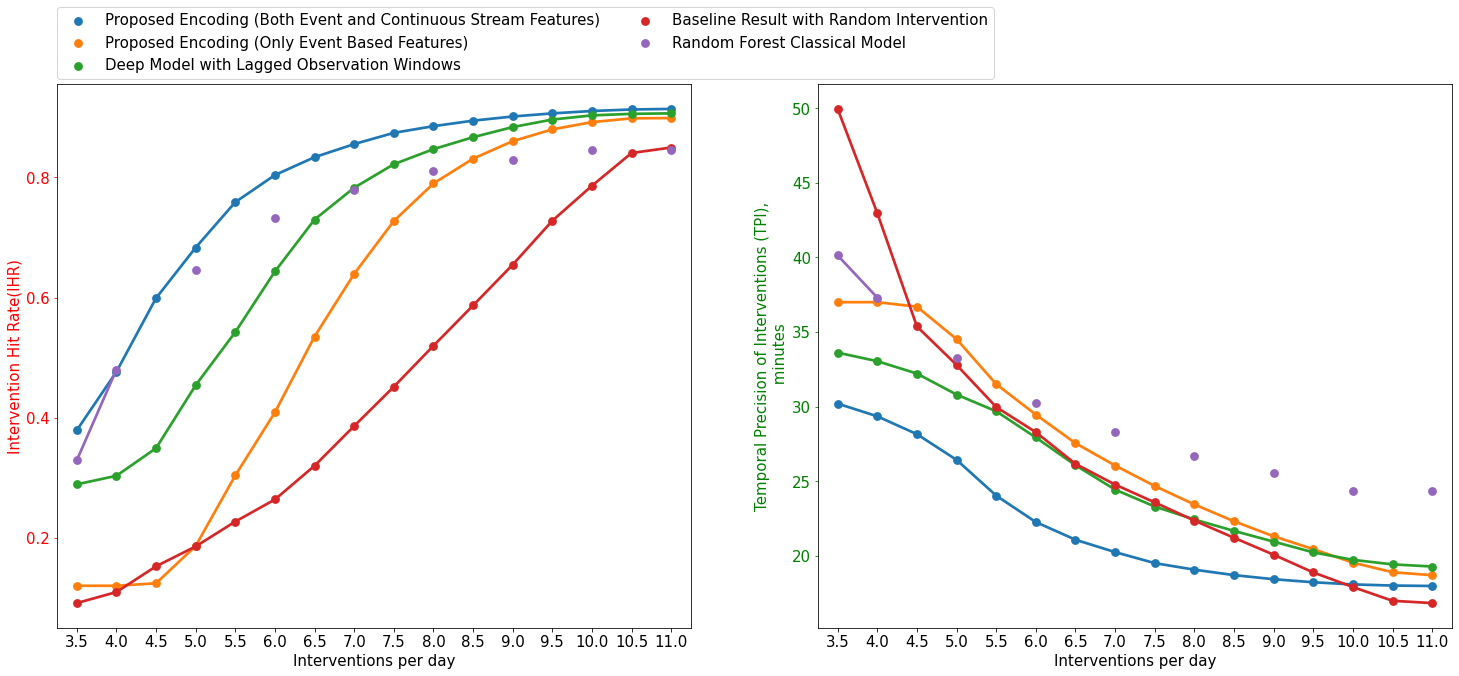

In [59]:
# final_recall = [0.75, 0.7307692307692307, 0.7307692307692307, 0.6923076923076923, 0.7115384615384616, 0.6153846153846154, 0.5961538461538461, 0.4230769230769231, 0.25, 0.2692307692307692, 0.21153846153846154, 0.11538461538461539, 0.11538461538461539]
# 0.6923076923076923
# final_intpday = [11.761467889908257, 8.81651376146789, 7.110091743119266, 5.972477064220183, 5.284403669724771, 4.706422018348624, 4.275229357798165, 3.926605504587156, 3.614678899082569, 3.4128440366972477, 3.1743119266055047, 3.055045871559633, 2.963302752293578]
# final_gap = [23.96153846153846, 25.346153846153847, 27.346153846153847, 29.807692307692307, 30.076923076923077, 32.69230769230769, 36.26923076923077, 36.69230769230769, 38.92307692307692, 39.34615384615385, 42.80769230769231, 43.46153846153846, 45.15384615384615]


# final_recall = [0.6923076923076923, 0.6923076923076923, 0.6923076923076923, 0.6730769230769231, 0.5961538461538461, 0.6153846153846154, 0.46153846153846156, 0.3076923076923077, 0.21153846153846154, 0.25, 0.19230769230769232, 0.09615384615384616, 0.038461538461538464]
# 0.6153846153846154
# final_intpday = [9.972477064220184, 7.89908256880734, 6.458715596330276, 5.541284403669724, 4.972477064220183, 4.495412844036697, 4.045871559633028, 3.7339449541284404, 3.4862385321100917, 3.2660550458715596, 3.1376146788990824, 3.0091743119266057, 2.81651376146789]
# final_gap = [25.115384615384617, 26.884615384615383, 28.846153846153847, 31.153846153846153, 31.96153846153846, 34.15384615384615, 37.61538461538461, 40.23076923076923, 41.23076923076923, 41.38461538461539, 41.23076923076923, 43.84615384615385, 49.92307692307692]


final_recall = [0.8461538461538461, 0.7692307692307693, 0.75, 0.75, 0.6923076923076923, 0.6346153846153846, 0.5192307692307693, 0.3076923076923077, 0.2692307692307692, 0.23076923076923078, 0.21153846153846154, 0.11538461538461539, 0.038461538461538464]
final_intpday = [9.972477064220184, 7.89908256880734, 6.458715596330276, 5.541284403669724, 4.972477064220183, 4.495412844036697, 4.045871559633028, 3.7339449541284404, 3.4862385321100917, 3.2660550458715596, 3.1376146788990824, 3.0091743119266057, 2.81651376146789]
final_gap = [25.115384615384617, 26.884615384615383, 28.846153846153847, 31.153846153846153, 31.96153846153846, 34.15384615384615, 37.61538461538461, 40.23076923076923, 41.23076923076923, 41.38461538461539, 41.23076923076923, 43.84615384615385, 49.92307692307692]


result =  get_smoothed_result(final_intpday,final_recall,final_gap)
x = np.array([3.5]+list(np.arange(4,12,1)))
result= get_interpolated_data(result,x,name='Overall',iteration=1)
result
temp_data = []
for a in result:
    temp_data.append([a[0],a[1],a[2],'Overall','Random Forest Classical Model',0])
df4 = pd.DataFrame(temp_data,columns=['Interventions per day','IHR','TPI','Subtype','Encoding','Iteration'])
df_final = pd.concat([df,df4])

plt.rcParams.update({'font.size':15})
fig,ax = plt.subplots(1,2,figsize=(25,10),sharex=False)
sns.pointplot(x='Interventions per day',y='IHR',hue='Encoding',data=df_final[df_final.Subtype.isin(['Overall'])],ci=None,ax=ax[0])
plt.legend(loc='lower right')
# ax[0].grid()
ax[0].set_ylabel('Intervention Hit Rate(IHR)',color='r')
ax[0].legend([],[], frameon=False)
ax[0].tick_params(axis='y', colors='red')
# ax1=ax.twinx()
sns.pointplot(x='Interventions per day',y='TPI',hue='Encoding',data=df_final[df_final.Subtype.isin(['Overall'])],ci=None,ax=ax[1])
ax[1].set_ylabel('Temporal Precision of Interventions (TPI),\n minutes',color='g')
ax[1].tick_params(axis='y', colors='g')
# ax[1].grid()
ax[1].legend(loc=(-1.2,1.01),ncol=2)
# plt.tight_layout()
plt.savefig('./data/images/deep_model.png')
# plt.tight_layout()
plt.show()

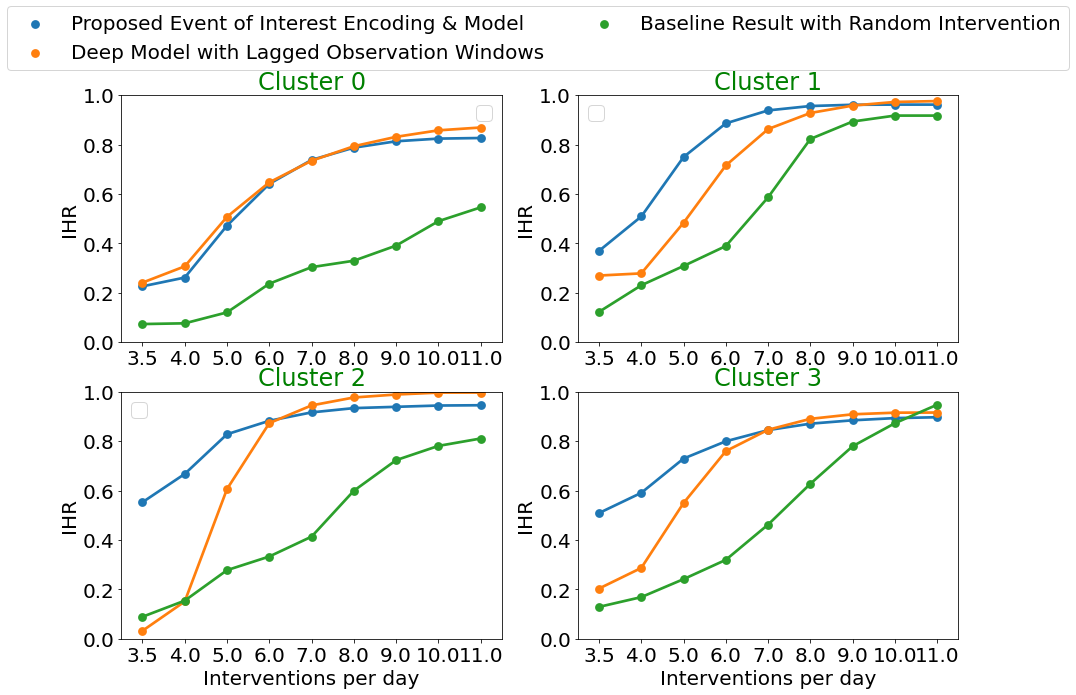

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
# df  = pickle.load(open('./data/saved_result/ihr_tpi_dataframe.p','rb'))
plt.rcParams.update({'font.size':20})
fig,ax = plt.subplots(2,2,figsize=(15,10),sharey=False)
ax = np.array(ax).reshape((2,2))
sns.pointplot(x='Interventions per day',y='IHR',hue='Encoding',data=df[df.Subtype.isin(['Cluster 0'])],ci=None,ax=ax[0,0])
ax[0,0].set_ylim([0,1])
ax[0,0].set_xlabel('')
ax[0,0].set_title('Cluster 0',color='g')
ax[0,0].legend([],[])
sns.pointplot(x='Interventions per day',y='IHR',hue='Encoding',data=df[df.Subtype.isin(['Cluster 1'])],ci=None,ax=ax[0,1])
ax[0,1].set_ylim([0,1])
ax[0,1].set_xlabel('')
ax[0,1].set_title('Cluster 1',color='g')
ax[0,1].legend([],[])
sns.pointplot(x='Interventions per day',y='IHR',hue='Encoding',data=df[df.Subtype.isin(['Cluster 2'])],ci=None,ax=ax[1,0])
ax[1,0].set_ylim([0,1])
ax[1,0].set_title('Cluster 2',color='g')
ax[1,0].legend([],[])
sns.pointplot(x='Interventions per day',y='IHR',hue='Encoding',data=df[df.Subtype.isin(['Cluster 3'])],ci=None,ax=ax[1,1])
ax[1,1].set_ylim([0,1])
ax[1,1].set_title('Cluster 3',color='g')
ax[1,1].legend(loc=(-1.5,2.3),ncol=2)


# plt.show()
# plt.figure(figsize=(20,10))
# sns.pointplot(x='Interventions per day',y='TPI',hue='Subtype',data=df[df.Encoding.isin(['Proposed Episode Encoding']) & ~df.Subtype.isin(['Overall'])],ci='sd',ax=ax[1])
# plt.tight_layout()
# plt.savefig('./data/images/cluster_performance.png')
plt.show()

No handles with labels found to put in legend.


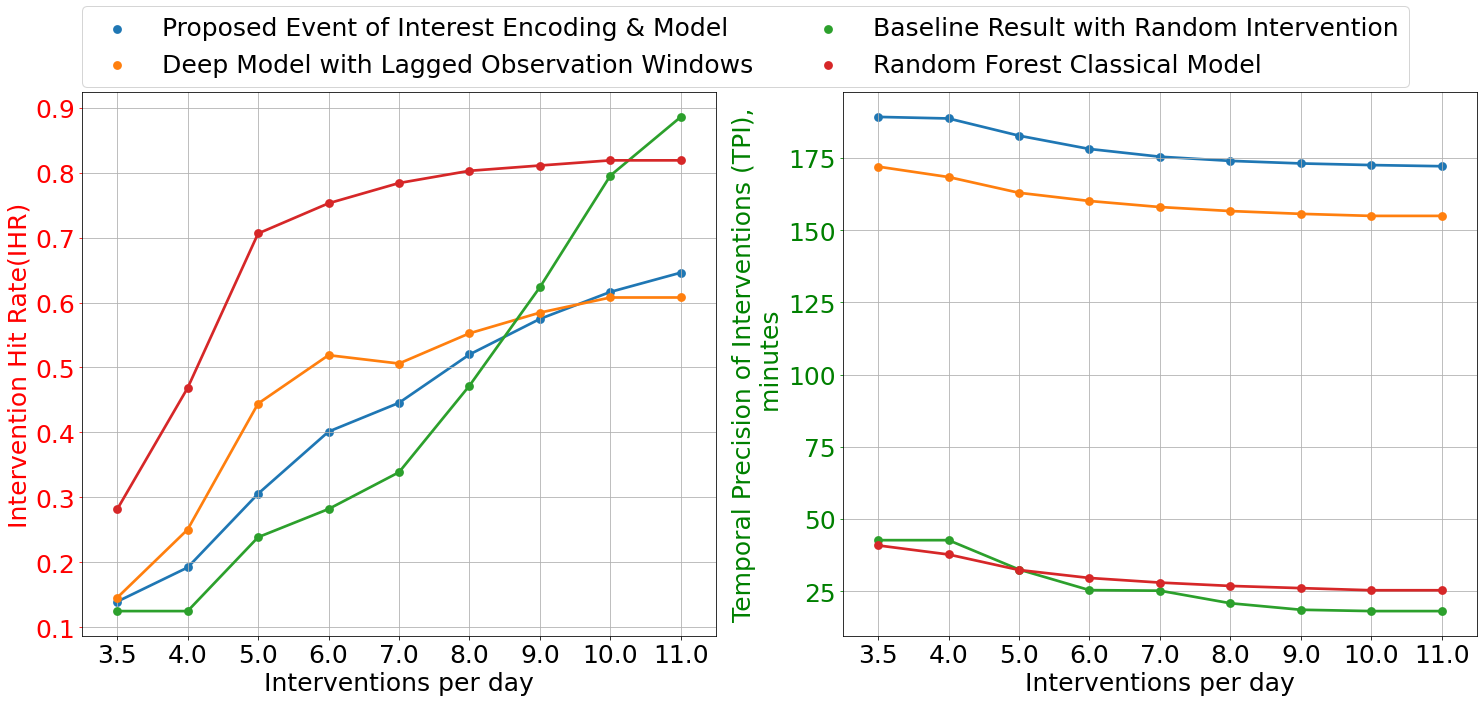

In [143]:
# df1['Encoding'] = ['Proposed Episode Encoding']*df.shape[0]
df_final[df_final.Subtype.isin(['Overall'])].groupby(['Encoding','Interventions per day']).mean()

IHR  \
Encoding                                    Interventions per day             
Baseline Result with Random Intervention    3.5                    0.093294   
                                            4.0                    0.112185   
                                            5.0                    0.197399   
                                            6.0                    0.284815   
                                            7.0                    0.367104   
                                            8.0                    0.530783   
                                            9.0                    0.668444   
                                            10.0                   0.785047   
                                            11.0                   0.839617   
Deep Model with Lagged Observation Windows  3.5                    0.247923   
                                            4.0                    0.264146   
                                            5.0                    0.511966   
                                            6.0                    0.743315   
                                            7.0                    0.817745   
                                            8.0                    0.877670   
                                            9.0                    0.904566   
                                            10.0                   0.913803   
                                            11.0                   0.917913   
Proposed Event of Interest Encoding & Model 3.5                    0.296424   
                                            4.0                    0.312634   
                                            5.0                    0.543645   
                                            6.0                    0.748742   
                                            7.0                    0.821479   
                                            8.0                    0.880761   
                                            9.0                    0.908063   
                                            10.0                   0.916771   
                                            11.0                   0.919925   
Random Forest Classical Model               3.5                    0.281492   
                                            4.0                    0.468487   
                                            5.0                    0.706458   
                                            6.0                    0.752976   
                                            7.0                    0.784192   
                                            8.0                    0.803022   
                                            9.0                    0.811193   
                                            10.0                   0.819139   
                                            11.0                   0.819139   

                                                                         TPI  \
Encoding                                    Interventions per day              
Baseline Result with Random Intervention    3.5                    48.839166   
                                            4.0                    42.466078   
                                            5.0                    32.095059   
                                            6.0                    27.313899   
                                            7.0                    25.521935   
                                            8.0                    21.605884   
                                            9.0                    19.427329   
                                            10.0                   18.217498   
                                            11.0                   17.772288   
Deep Model with Lagged Observation Windows  3.5                    37.606293   
                                            4.0                    36.856239   
                             

In [88]:
data_eval = pickle.load(open('./data/abc_random_30_60_r07.p','rb'))
y_time = np.array([a[0] for a in data_eval])
y_pred = np.array([np.array([a[1]]*50) for a in data_eval])
y_test = np.array([a[2] for a in data_eval])
y_pid = np.array([a[3] for a in data_eval])
val_results = {}

In [194]:
pickle.dump(df_final,open('./data/saved_result/df_final.p','wb'))

In [84]:
pickle.dump([y_time,y_pred,y_test,y_pid,val_results,val_results],open(data_directory+str(n_lag)+'random_forest.p','wb'))

In [85]:
y_pred[0]

array([0.22929929, 0.22929929, 0.22929929, 0.22929929, 0.22929929,
       0.22929929, 0.22929929, 0.22929929, 0.22929929, 0.22929929,
       0.22929929, 0.22929929, 0.22929929, 0.22929929, 0.22929929,
       0.22929929, 0.22929929, 0.22929929, 0.22929929, 0.22929929,
       0.22929929, 0.22929929, 0.22929929, 0.22929929, 0.22929929,
       0.22929929, 0.22929929, 0.22929929, 0.22929929, 0.22929929,
       0.22929929, 0.22929929, 0.22929929, 0.22929929, 0.22929929,
       0.22929929, 0.22929929, 0.22929929, 0.22929929, 0.22929929,
       0.22929929, 0.22929929, 0.22929929, 0.22929929, 0.22929929,
       0.22929929, 0.22929929, 0.22929929, 0.22929929, 0.22929929])

(56,)

In [160]:
df2['Encoding'] = ['Using Features from Past episodes']*df.shape[0]

In [161]:
df = pd.concat([df1,df2])

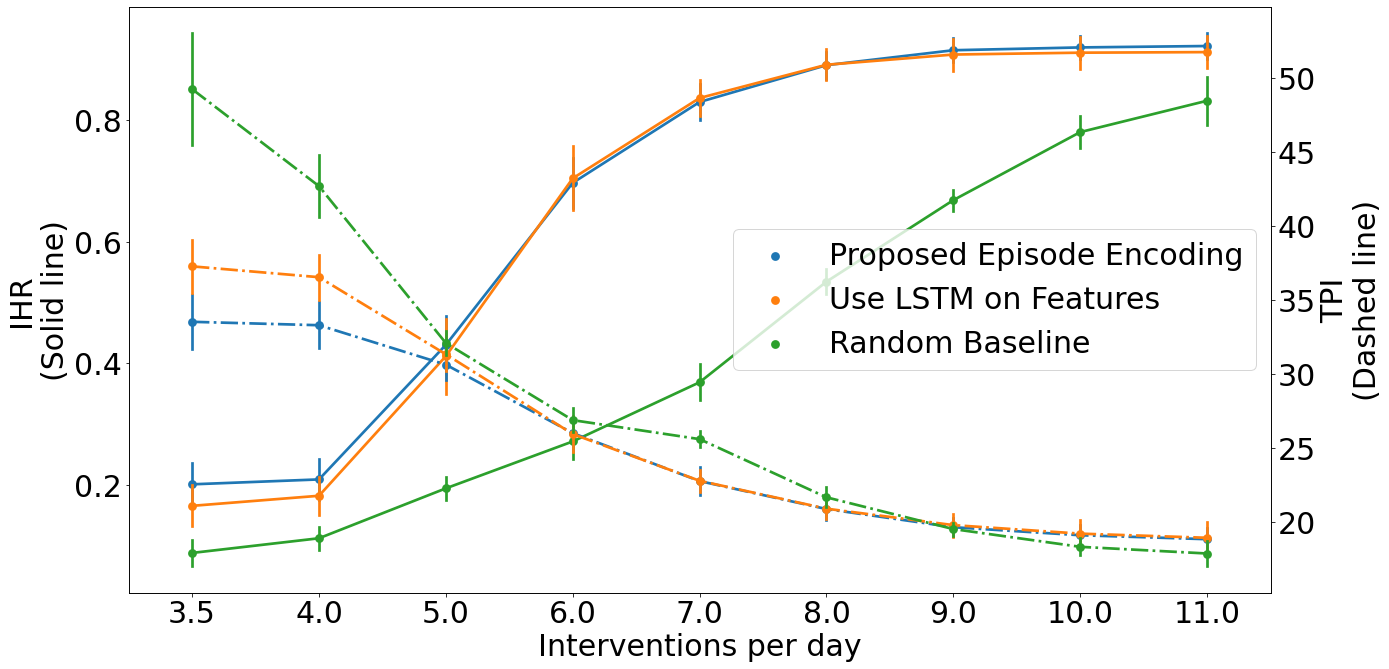

In [70]:
plt.rcParams.update({'font.size':30})
fig,ax = plt.subplots(1,1,figsize=(20,10))
sns.pointplot(x='Interventions per day',y='IHR',hue='Encoding',data=df[df.Subtype=='Overall'],ci='sd')
ax.set_ylabel('IHR\n(Solid line)')
plt.legend(loc='center right')
ax1 = ax.twinx()
g = sns.pointplot(x='Interventions per day',y='TPI',hue='Encoding',data=df[df.Subtype=='Overall'],ci='sd',ax=ax1,linestyles='-.')
ax1.set_ylabel('TPI\n(Dashed line)')
# ax1._remove_legend()
plt.legend([],[], frameon=False)
plt.tight_layout()
plt.savefig('./data/images/encoding_type.png')

In [181]:
pickle.dump(df,open('./data/saved_result/ihr_tpi_dataframe.p','wb'))

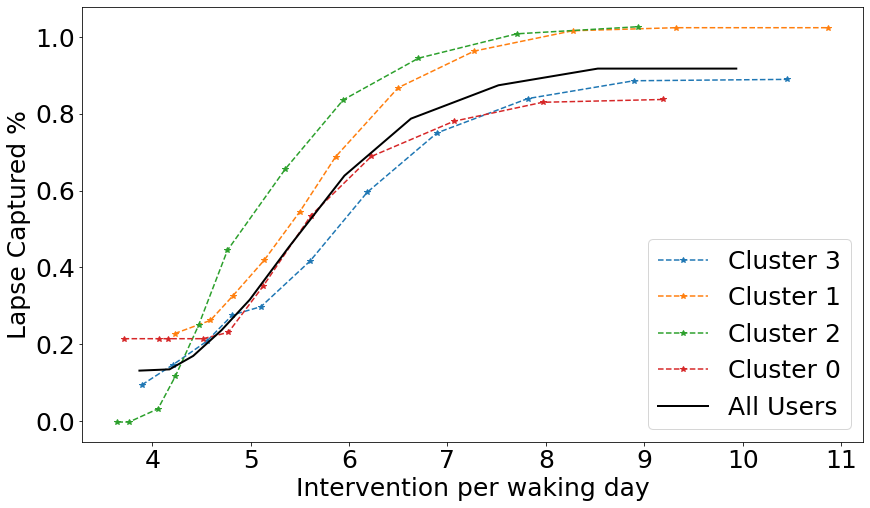

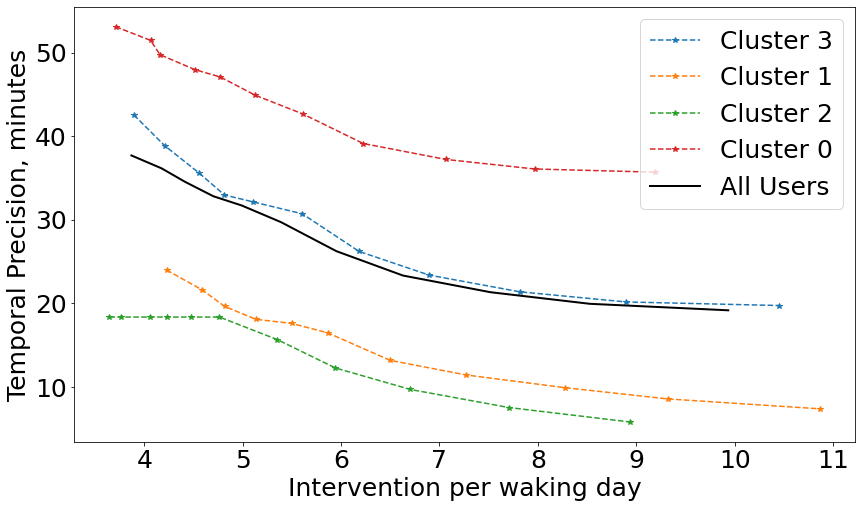

array([[ 3.87037037,  0.13118581, 37.68253968],
       [ 4.17592593,  0.13445378, 36.14565826],
       [ 4.41666667,  0.16946779, 34.51820728],
       [ 4.7037037 ,  0.23622782, 32.80018674],
       [ 4.99074074,  0.3155929 , 31.70028011],
       [ 5.38888889,  0.45284781, 29.71148459],
       [ 5.9537037 ,  0.63865546, 26.22875817],
       [ 6.62962963,  0.78711485, 23.3155929 ],
       [ 7.51851852,  0.87394958, 21.32212885],
       [ 8.52777778,  0.91736695, 19.93557423],
       [ 9.93518519,  0.91736695, 19.15592904]])

In [58]:
plt.figure(figsize=(14,8))
for key in result_phenotypes_final.keys():
    plt.plot(result_phenotypes_final[key][:,0],result_phenotypes_final[key][:,1],'--*',label='Cluster {}'.format(key))
plt.plot(result_final[:,0],result_final[:,1],linewidth=2,c='k',label='All Users')
plt.ylabel('Lapse Captured %')
plt.xlabel('Intervention per waking day')
plt.legend()
plt.show()
plt.figure(figsize=(14,8))
for key in result_phenotypes_final.keys():
    plt.plot(result_phenotypes_final[key][:,0],result_phenotypes_final[key][:,2],'--*',label='Cluster {}'.format(key))
plt.plot(result_final[:,0],result_final[:,2],linewidth=2,c='k',label='All Users')
plt.ylabel('Temporal Precision, minutes')
plt.xlabel('Intervention per waking day')
plt.legend()
plt.show()
result_final


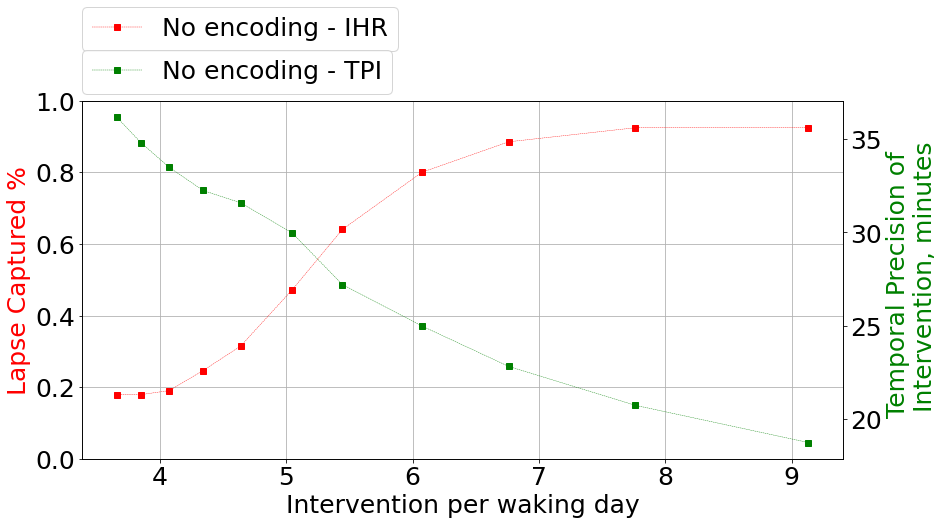

In [54]:
# pprint(result_final)

plt.rcParams.update({'font.size':25})
plt.figure(figsize=(14,8))
plt.plot(result_final[:,0],result_final[:,1],c='r',linewidth=.4,linestyle='--',marker='s',label='No encoding - IHR')
# plt.plot(result_episode[:,0],result_episode[:,1],c='r',linewidth=1,linestyle='--',marker='d',label='Episode encoding - IHR')
plt.legend(loc=(0,1.14),ncol=2)
plt.grid()
ax = plt.gca()
ax2 = ax.twinx()
ax2.plot(result_final[:,0],result_final[:,2],c='g',marker='s',linestyle='--',linewidth=.4,label='No encoding - TPI')
# ax2.plot(result_episode[:,0],result_episode[:,2],c='g',marker='d',linewidth=1,linestyle='--',label='Episode encoding - TPI')
plt.legend(loc=(0,1.02),ncol=2)
ax2.set_ylabel('Temporal Precision of \n Intervention, minutes',c='g')
ax.set_ylabel('Lapse Captured %',c='r')
ax.set_xlabel('Intervention per waking day')
# ax.set_yticks(c='r')
plt.tight_layout()
ax.set_ylim([0,1])
plt.show()


In [646]:
result_episode = result_final.copy()
# result_final

In [619]:
# pickle.dump([result_final,result_episode],open('./data/saved_result/ihr_tpi.p','wb'))

0.8823529411764706
[(16.925925925925927, 0.9607843137254902, 0.9547152194211014),
 (12.925925925925926, 0.9607843137254902, 0.9495798319327728),
 (10.601851851851851, 0.9019607843137255, 0.9313725490196076),
 (8.907407407407407, 0.8823529411764706, 0.9000933706816067),
 (7.87962962962963, 0.8823529411764706, 0.8636788048552761),
 (6.944444444444445, 0.8235294117647058, 0.8188608776844079),
 (6.25, 0.7058823529411765, 0.6993464052287588),
 (5.7592592592592595, 0.5882352941176471, 0.551820728291317),
 (5.268518518518518, 0.35294117647058826, 0.41549953314659244),
 (4.953703703703703, 0.3333333333333333, 0.3370681605975727),
 (4.657407407407407, 0.29411764705882354, 0.27871148459383766),
 (4.416666666666667, 0.3137254901960784, 0.25210084033613456),
 (4.194444444444445, 0.21568627450980393, 0.25723622782446326)]


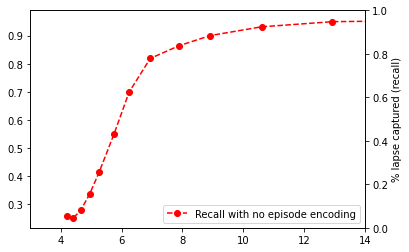

In [450]:

final_recall = np.array(final_recall)
final_intpday = np.array(final_recall)
final_recall1 = savgol_filter(final_recall,7 , 2) # window size 13, polynomial order 5
final_gap1 = savgol_filter(final_gap,7 , 2)
previous = savgol_filter(aaa[1],7,2)
print(np.median(final_recall[:9]))
from pprint import pprint

# print(final_intpday)
# print(final_gap)
import matplotlib.pyplot as plt
plt.plot(final_intpday,final_recall1,linestyle='--', marker='o', color='r',label='Recall with no episode encoding')
# plt.plot(final_intpday,final_gap,linestyle='--', marker='o', color='g',label='Precision')
# plt.plot(aaa[0],previous,linestyle='--', marker='o', color='g',label="Recall with episode encoding")
pprint(list(zip(final_intpday,final_recall,final_recall1)))
plt.legend()
ax = plt.gca()
ax2=ax.twinx()
# ax2.plot(final_intpday,final_gap1)
plt.xlabel('Interventions per day')
plt.ylabel('% lapse captured (recall)')
plt.xlim([3,14])
# plt.ylabel('Gap between ID and Lapse')
# plt.ylim(30, 80)

plt.show()



lag = 60, 45 minutes:
    Recall
    Temporal precision
    (Smooth)

phenotyping




In [421]:
aaa = [final_intpday,final_recall,final_gap]

In [9]:
smoking_cross_entropy = [final_intpday,final_recall]

In [5]:
smoking_focal = [final_intpday,final_recall]

In [ ]:
import matplotlib.pyplot as plt

plt.plot(aaa[0],aaa[1],linestyle='--', marker='o', color='r',label='LR')
plt.xlabel('Interventions per day')
# plt.ylabel('% lapse captured (recall)')
plt.ylabel('Gap between ID and Lapse')
# plt.ylim(30, 80)
plt.legend()
plt.show()

In [ ]:
aaa = [final_intpday,final_recall]

In [171]:
data_eval = pickle.load(open(data_directory+str(n_lag)+'random_forest.p','rb'))
        # '_episode_model_v9_new_validation_set_include_smoking_focal_loss_static_coeff_phenotype_lower_model_v2.p','rb'))
y_time = data_eval[0]
y_pred = np.mean(np.array(data_eval[1]),axis=1)
y_test = data_eval[2]
bias = f1Bias_scorer_CV(y_pred,y_test)[1]
# y_pred = np.array(y_pred>=bias,dtype=int)
y_pid = data_eval[3]
df = pd.DataFrame({'pred':y_pred,'user':y_pid,'test':y_test})
f1_scores_rf = df.groupby('user').apply(lambda a:f1Bias_scorer_CV(a['pred'],a['test'])[0]).values

In [172]:
data_eval = pickle.load(open(data_directory+str(n_lag)+
        '_episode_model_v9_new_validation_set_include_smoking_focal_loss_static_coeff_phenotype_lower_model_v2.p','rb'))
y_time = data_eval[0]
y_pred = np.mean(np.array(data_eval[1]),axis=1)
y_test = data_eval[2]
y_pid = data_eval[3]
df = pd.DataFrame({'pred':y_pred,'user':y_pid,'test':y_test})
f1_scores = df.groupby('user').apply(lambda a:f1Bias_scorer_CV(a['pred'],a['test'])[0]).values

(array([11.,  6.,  8.,  4.,  3.,  6.,  6.,  2.,  1.,  4.]),
 array([0.06783145, 0.15670048, 0.24556951, 0.33443854, 0.42330757,
        0.51217659, 0.60104562, 0.68991465, 0.77878368, 0.86765271,
        0.95652174]),
 <BarContainer object of 10 artists>)

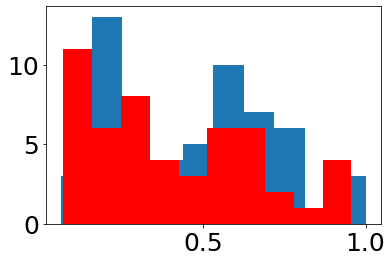

In [173]:
plt.hist(f1_scores_rf)
plt.hist(f1_scores,color='r')
# # plt.boxplot([f1_scores,f1_scores_rf])
# sns.histplot(x=f1_scores)
# sns.histplot(x=f1_scores_rf)
